# The impact of extreme weather events using hurricane Sandy Oct 2012

Hurricane Sandy was the deadliest, the most destructive, and the strongest hurricane of the 2012 Atlantic hurricane season. 
The storm inflicted nearly $70 billion (2012 USD) in damage and killed 233 people across eight countries from the Caribbean to Canada.

<img src="images/hurricane_sandy_airports.png" width=800 height=600 />

https://www.tableau.com/solutions/gallery/storm-tracking

## Hypothesis

- H1: The are significant differences between the weather data compared to the year before.
- H2: Significant changes in diverted flights with destinations to the 6 airports.
- H3: There is a threshold (average temperature, wind, rain) until the flights are cancelled.

	- Airports
		- Boston (BOS)
		- Miami (MIA)
		- Newark (EWR)
		- New York (JFK)
		- Philadelphia (PHL)
		- Purto Rico (SJU)

## Get flights and weather data
- Download flights data from a website
- Download weather data from meteostat via API and meteostat Python library

# 1. Download flights data from a website

In [19]:
# Import all necessary libraries
# Import python packages 
import pandas as pd
import numpy as np
from zipfile import * #package for unzipping zip files
import datetime as dt
import matplotlib.pyplot as plt
import requests
import seaborn as sns

from IPython.display import display # in order to show display not as error

# Import from own modules
import sql as gd
import api # connection
from sql import get_conn, get_engine, get_data  #adjust this as necessary to match your sql.py connection methods

# Change options
pd.set_option('display.max_columns', None)

In [2]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [3]:
# Download flights data

years = [2011, 2012] # list of years you want to look at, specify one year
months = [10, 11, 12] # list of months you want to look at, specify one month
# Here: October, November, October 2011 and 2012 / 1 file ca. 23 mb

# Loop through months
for year in years:
    for month in months:
        # Get the file from the website https://transtats.bts.gov
        zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        csv_file = f'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv'
        url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
        # Download the database
        r = requests.get(f'{url}', verify=False)
        # Save database to local file storage
        with open(path+zip_file, 'wb') as f:
            f.write(r.content)

/usr/local/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/

In [4]:
# Unzip your files (220Mb/per file)
for year in years:
    for month in months:
        zip_files = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        with ZipFile(path+zip_files, 'r') as zip_ref:
            zip_ref.extractall(path)

In [5]:
# Read in your data DOESNT WORK YET
# df = pd.DataFrame(data=None)
# for year in years:
#     for month in months:
#         appended_flights = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv', low_memory = False)
#         df.append(appended_flights)

# pd.concat([all_df], axis=0)
# Read in csv data in df
flights_df_2011_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_10.csv', low_memory = False)
flights_df_2011_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_11.csv', low_memory = False)
flights_df_2011_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_12.csv', low_memory = False)
flights_df_2012_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_10.csv', low_memory = False)
flights_df_2012_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_11.csv', low_memory = False)
flights_df_2012_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_12.csv', low_memory = False)
# Combine your date, use a function
flights_df1 = flights_df_2011_10.append(flights_df_2011_11)
flights_df2 = flights_df1.append(flights_df_2011_12)
flights_df3 = flights_df2.append(flights_df_2012_10)
flights_df4 = flights_df3.append(flights_df_2012_11)
df = flights_df4.append(flights_df_2012_12)

# 2. Prepare the csv file for further processing

In the next step, we clean and prepare our dataset.

In [6]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [7]:
# set up your database connection
engine = get_engine()

In [8]:
# The columns in the DB have different naming as in the source csv files. Lets get the names from the DB
table_name_sql = '''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='public'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [9]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'distance',
 'cancelled',
 'diverted']

In [10]:
# Just in case the above fails here are the results
new_column_names_alternate = ['flight_date',
                              'dep_time',
                              'sched_dep_time',
                              'dep_delay',
                              'arr_time',
                              'sched_arr_time',
                              'arr_delay',
                              'airline',
                              'tail_number',
                              'flight_number',
                              'origin',
                              'dest',
                              'air_time',
                              'distance',
                              'cancelled',
                              'diverted' ]

b) With the next function, we make our csv file ready to be uploaded to SQL.  
We only keep to above specified columns and convert the datatypes.

In [11]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [12]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


If you decide to only look at specific airports, it is a good decision to filter for them in advance.  
This function does the filtering. 

In [13]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering airline df for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [14]:
# Execute function, filtering for New York area airports
airports=['BOS', 'EWR', 'JFK', 'MIA', 'PHI', 'SJU']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


# 3. Push the prepared data to a table in the database

In [15]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table
table_name = 'group4_flights_data'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This will take a minute or two...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The group4_flights_data table was imported successfully.


In [16]:
# Check the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

# 4. Download weather_data with API and meteostat

In [20]:
# Download airport data from faa

# from https://www.faa.gov/airports/airport_safety/airportdata_5010/menu/#datadownloads
airports_df = pd.read_sql('SELECT * FROM airports_info', get_conn())

# filter only rows of the 6 airports we are interested in
locations = airports_df[airports_df['faa'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]

# create a list of icao ids of the location to pass to the API
icao_list = locations['icao'].tolist()

In [ ]:
# Download weather data from us and pr from meteostat and save csv file
# api.get_weather_stations('US', 'data/us_weather_stations.csv')
# api.get_weather_stations('PR', 'data/pr_weather_stations.csv')

In [21]:
# find the weather stations near the 6 relevant airports
us_stations_df = pd.read_csv('data/us_weather_stations.csv')

# create dataframe of weather stations in Puerto Rico
pr_stations_df = pd.read_csv('data/pr_weather_stations.csv')

# create a dataframe of all weather stations in US and Puerto Rico
all_weather_stations_df = pd.concat([us_stations_df, pr_stations_df], axis=0)

# filter dataframe on the icao identifiers of the 6 airports
weather_stations_df = all_weather_stations_df[all_weather_stations_df['icao'].isin(icao_list)]
display(weather_stations_df)

,id,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
110,72202,Miami International Airport,US,FL,72202.0,KMIA,25.7833,-80.3167,4.0,America/New_York,1973-01-01,2021-11-07,1948-01-01,2021-11-05,1948-01-01,2021-01-01
266,72408,Philadelphia International Airport,US,PA,72408.0,KPHL,39.8667,-75.2333,6.0,America/New_York,1973-01-01,2021-11-07,1940-07-01,2021-11-04,1940-01-01,2021-01-01
336,72502,Newark Airport,US,NJ,72502.0,KEWR,40.6833,-74.0000,5.0,America/New_York,1973-01-01,2021-11-07,1893-01-01,2021-11-04,1893-01-01,2021-01-01
343,72509,Boston Logan International,US,MA,72509.0,KBOS,42.3667,-71.0167,6.0,America/New_York,1943-11-21,2021-11-07,1936-01-01,2021-11-04,1936-01-01,2021-01-01
532,74486,John F. Kennedy Airport,US,NY,74486.0,KJFK,40.6333,-73.7667,4.0,America/New_York,1973-01-01,2021-11-07,1948-07-17,2021-11-04,1948-01-01,2021-01-01
0,78526,"San Juan / Int., Puerto Rico",PR,NaN,78526.0,TJSJ,18.4333,-66.0000,3.0,America/Puerto_Rico,2005-01-01,2021-11-07,1941-06-17,2021-11-02,1941-01-01,2021-01-01


In [22]:
# airports from SQL 'BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU' 
airports = get_data('''SELECT city,
                   faa,
                   -- name,
                   lat,
                   lon,
                   alt
            FROM airports
            WHERE faa IN ( 'BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU' )
            LIMIT 5''')

,city,faa,lat,lon,alt
0,San Juan,SJU,18.439400,-66.001801,9
1,Boston,BOS,42.364300,-71.005203,20
2,Newark,EWR,40.692501,-74.168701,18
3,Miami,MIA,25.793200,-80.290604,8
4,Philadelphia,PHL,39.871899,-75.241096,36


In [23]:
# in order to use lat and lon values I am going to create a dictionary with:
    # key = icao
    # values = latitude, longitude
stations_dict = dict()
for i in range(len(weather_stations_df)):
    key = weather_stations_df['icao'].iloc[i]
    stations_dict[key] = weather_stations_df['latitude'].iloc[i], weather_stations_df['longitude'].iloc[i]
    
display(stations_dict)

{'KMIA': (25.7833, -80.3167),
 'KPHL': (39.8667, -75.2333),
 'KEWR': (40.6833, -74.0),
 'KBOS': (42.3667, -71.0167),
 'KJFK': (40.6333, -73.7667),
 'TJSJ': (18.4333, -66.0)}

In [ ]:
# start = dt.datetime(2012, 10, 1)
# end = dt.datetime(2012, 12, 31) 
# api.get_weather_daily(stations_dict, start, end, 'data/weather_2012_4quarter.csv')

In [ ]:
#start = dt.datetime(2011, 10, 1)
#end = dt.datetime(2011, 12, 31) 
#api.get_weather_daily(stations_dict, start, end, 'data/weather_2011_4quarter.csv')

In [2]:
# Code	Meaning
# TEMP	Air Temperature
# TAVG	Average Temperature
# TMIN	Minimum Temperature
# TMAX	Maximum Temperature
# DWPT	Dew Point
# PRCP	Total Precipitation
# WDIR	Wind Direction
# WSPD	Average Wind Speed
# WPGT	Wind Peak Gust
# RHUM	Relative Humidity
# PRES	Sea-Level Air Pressure
# SNOW	Snow Depth
# TSUN	Total Sunshine Duration
# COCO	Weather Condition Code

In [24]:
# create a dataframe with the weather data
weather_df_2011 = pd.read_csv('data/weather_2011_4quarter.csv')
weather_df_2012 = pd.read_csv('data/weather_2012_4quarter.csv')

# change time column to datatime data type
weather_df_2011['time'] = pd.to_datetime(weather_df_2011['time'])
weather_df_2012['time'] = pd.to_datetime(weather_df_2012['time'])

# drop the empty column wpgt
weather_df_2011.drop('wpgt', axis=1, inplace=True)
weather_df_2012.drop('wpgt', axis=1, inplace=True)

# create weather_df to upload the data of both years in one file
weather_df = pd.concat([weather_df_2011, weather_df_2012], axis=0)

display(weather_df_2011.head(2))
display(weather_df_2012.head(2))

,time,icao,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,tsun
0,2011-10-01,KMIA,28.1,23.9,32.2,0.0,NaN,NaN,8.3,1010.3,702.0
1,2011-10-02,KMIA,26.9,23.9,30.6,0.0,NaN,49.3,13.0,1013.8,689.0


,time,icao,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,tsun
0,2012-10-01,KMIA,26.7,24.4,28.3,45.0,NaN,NaN,10.8,1010.4,NaN
1,2012-10-02,KMIA,26.4,23.3,30.6,17.8,NaN,NaN,8.6,1014.4,NaN


In [25]:
# add an additional column with the 'icaoidentifier' to the weather df
weather_df = weather_df.merge(locations[['icao', 'faa']], how='left', on='icao')

# move 'faa' column to the first 2 position
weather_df = weather_df[['time', 'icao', 'faa', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir',
       'wspd', 'pres', 'tsun']]

In [10]:
# save weather data to database
# table_name = 'group4_weather_data'
# gd.save_to_db(weather_df, table_name)

## Join - Prepare Data for EDA

In [26]:
# SQL query to get the flights data
flights_df = pd.read_sql("SELECT * FROM public.group4_flights_data", get_conn())
flights_df.head(2)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0


In [3]:
# SQL query to get the weather data
# weather_df = pd.read_sql("SELECT * FROM public.group4_weather_data", get_conn())
# weather_df.head(2)

In [27]:
# Create unique identifier and left join flights with weather
flights_df['fk'] = flights_df['flight_date'].astype('str') + flights_df['origin'] # foreign key
weather_df['pk'] = weather_df['time'].astype('str') + weather_df['faa'] # primary key

# Left join flight_df with weather
flight_data = flights_df.merge(weather_df,
                                    how='left',
                                    left_on='fk',
                                    right_on='pk')
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389158 entries, 0 to 389157
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_date     389158 non-null  datetime64[ns]
 1   dep_time        379506 non-null  float64       
 2   sched_dep_time  389158 non-null  int64         
 3   dep_delay       379506 non-null  float64       
 4   arr_time        379210 non-null  float64       
 5   sched_arr_time  389158 non-null  int64         
 6   arr_delay       378602 non-null  float64       
 7   airline         389158 non-null  object        
 8   tail_number     386021 non-null  object        
 9   flight_number   389158 non-null  int64         
 10  origin          389158 non-null  object        
 11  dest            389158 non-null  object        
 12  air_time        378602 non-null  float64       
 13  distance        389158 non-null  float64       
 14  cancelled       389158 non-null  int

In [28]:
# Add column period month
flight_data['period_month'] = pd.to_datetime(flight_data["flight_date"]).dt.to_period('M')

# 5. EDA

In [29]:
# Cancellation
display(flight_data['cancelled'].sum())
display(flight_data.groupby('period_month').agg({'cancelled': ['sum']}))
display(flight_data.groupby(['period_month']).agg({'cancelled': ['sum']}).apply(lambda x: 100 * x / float(x.sum())))

9827

,cancelled
,sum
period_month,
2011-10,920
2011-11,333
2011-12,450
2012-10,5450
2012-11,1699
2012-12,975


,cancelled
,sum
period_month,
2011-10,9.361962
2011-11,3.388623
2011-12,4.579221
2012-10,55.459448
2012-11,17.289101
2012-12,9.921644


In [30]:
# work in progress
display(flight_data[flight_data['period_month'].dt.year == 2012].groupby(['icao']).agg({'cancelled': ['sum']}).apply(lambda x: 100 * x / float(x.sum())))
r_cancelled = flight_data.groupby(['icao', 'period_month'])[['cancelled']].sum()
r_cancelled = r_cancelled.reset_index()
r_cancelled[r_cancelled['period_month'].dt.year == 2012].groupby(['icao', 'period_month'])[['cancelled']].sum()

,cancelled
,sum
icao,
KBOS,18.167313
KEWR,46.341463
KJFK,24.230682
KMIA,7.248689
KPHL,1.686802
TJSJ,2.325051


cancelled
icao period_month           
KBOS 2012-10             615
     2012-11              88
     2012-12              94
KEWR 2012-10            1260
     2012-11             507
     2012-12             266
KJFK 2012-10             752
     2012-11             251
     2012-12              60
KMIA 2012-10             206
     2012-11              42
     2012-12              70
KPHL 2012-10              58
     2012-11               8
     2012-12               8
TJSJ 2012-10              72
     2012-11              16
     2012-12              14

In [31]:
plot_c = r_cancelled[r_cancelled['period_month'].dt.year == 2012].groupby(['icao', 'period_month'])[['cancelled']].sum()

In [135]:
fig, ax = plt.subplots
ax.bar(flights_da)
plt.show()

TypeError: cannot unpack non-iterable function object

<AxesSubplot:xlabel='flight_date'>

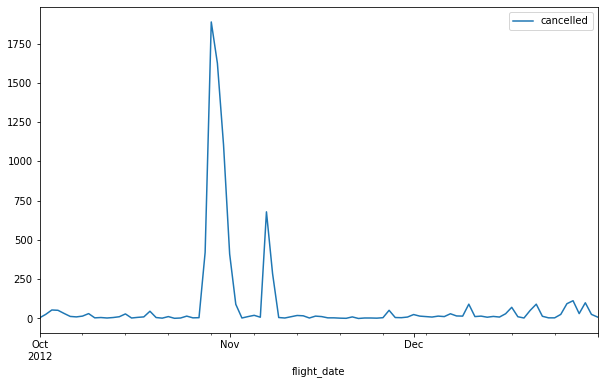

In [17]:
grouped_cancelled = flight_data[flight_data['flight_date'] >= '2012-10-01'].groupby('flight_date')[['cancelled']].sum()
grouped_cancelled.plot(figsize=(10,6))

In [32]:
flight_data.groupby('period_month').agg({'wspd': ['mean', 'min', 'max']})

wspd           
                   mean  min   max
period_month                      
2011-10       15.156535  4.7  32.4
2011-11       14.634273  2.5  31.7
2011-12       15.012097  2.2  32.4
2012-10       14.918710  2.5  58.3
2012-11       14.987723  1.4  37.1
2012-12       15.662376  1.4  41.0

In [33]:
# work in progress as fuck
r_cancelled = flight_data.groupby(['icao', 'period_month'])[['cancelled']].sum()
r_cancelled = r_cancelled.reset_index()
r_cancelled[r_cancelled['period_month'].dt.year == 2012]

,icao,period_month,cancelled
3,KBOS,2012-10,615
4,KBOS,2012-11,88
5,KBOS,2012-12,94
9,KEWR,2012-10,1260
10,KEWR,2012-11,507
11,KEWR,2012-12,266
15,KJFK,2012-10,752
16,KJFK,2012-11,251
17,KJFK,2012-12,60
21,KMIA,2012-10,206


## Hypothesis

## H1: The are significant differences between the weather data compared to the year before.

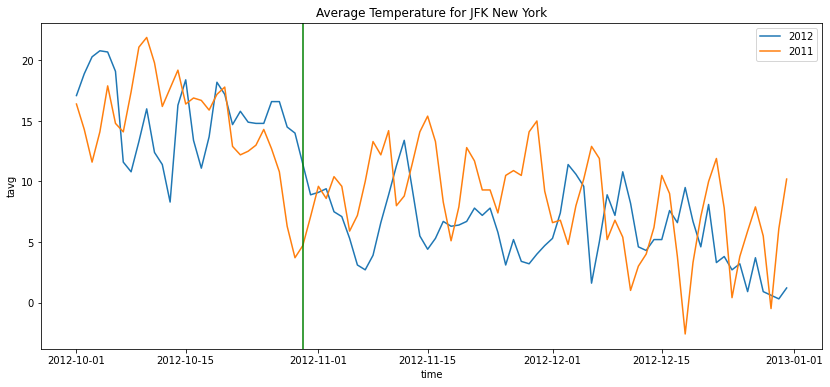

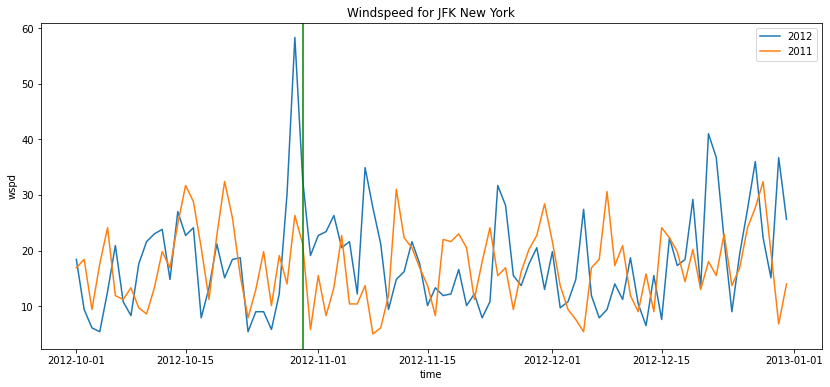

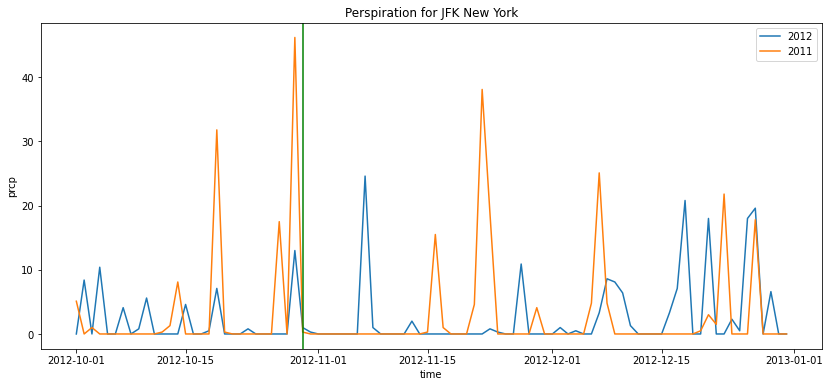

In [42]:
col_list = ['tavg', 'wspd', 'prcp']
col_names_list = ['Average Temperature', 'Windspeed', 'Perspiration']

for i, col in enumerate(col_list):
    fig, ax = plt.subplots(figsize=(14,6))

    x = weather_df_2012['time'][weather_df_2011['icao'] == 'KJFK']
    y1 = weather_df_2011[col]
    y2 = weather_df_2012[col]

    sns.lineplot(x=x, y=y2, ci=None, ax=ax, label='2012')
    sns.lineplot(x=x, y=y1, ci=None, ax=ax, label='2011')
    ax.axvline(dt.datetime(2012,10,30), color='green')
    ax.set_title(col_names_list[i] + ' for JFK New York')
    plt.show()

## H3: There is a threshold (average temperature, wind, rain) until the flights are cancelled.

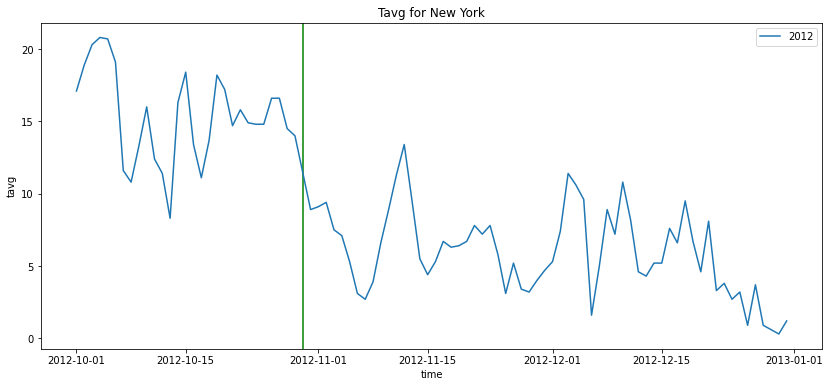

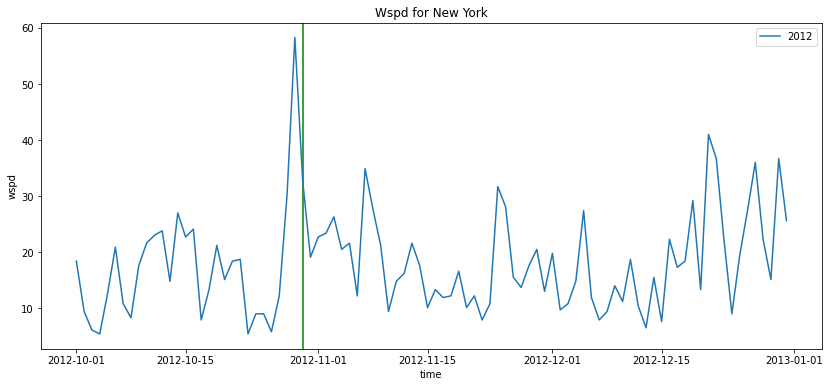

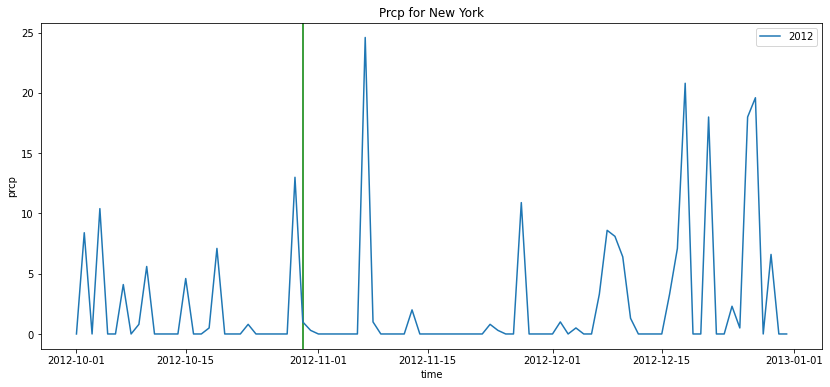

In [44]:
col_list = ['tavg', 'wspd', 'prcp']
ordered_airports = ['TJSJ', 'KMIA', 'KPHL', 'KJFK', 'KEWR', 'KBOS']

for col in col_list:
    fig, ax = plt.subplots(figsize=(14,6))

    x = weather_df_2012['time'][weather_df_2012['icao'] == 'KJFK']
    y = weather_df_2012[weather_df_2012['icao'] == 'KJFK'][col]
    # y2 = weather_df_2012[weather_df_2012['icao'] == 'KJFK']['sandy_day']
    # y2 = 
    ax.axvline(dt.datetime(2012,10,30), color='green')
    sns.lineplot(x=x, y=y, ci=None, ax=ax, label='2012')

    
    ax.set_title(col.capitalize() + ' for New York')
    #ax.legend()
    plt.show()

## H3: Significant changes in diverted flights with destinations to the 6 airports.


In [36]:
flights_amount_all = flights_df.groupby('dest').count()['flight_number'].sum()
display(flights_amount_all)

airports_6_df = flights_df[flights_df['dest'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]
flights_amount_6 = airports_6_df.groupby('dest').count()['flight_number'].sum()
display(flights_amount_6)
percentage_all_flights = round((flights_amount_6/flights_amount_all)*100, 2)

display(f'The 6 selected airports are destinations of {percentage_all_flights} % of all US flights')

diverted_all = flights_df[flights_df['diverted'] == 1]['diverted'].count()
display(diverted_all)

airports_6_df = flights_df[flights_df['dest'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]
diverted_6 = airports_6_df[airports_6_df['diverted'] == 1]['diverted'].count()
display(diverted_6)

percentage_diverted = round((diverted_6/diverted_all)*100, 2)
percentage_diverted

389158

212705

'The 6 selected airports are destinations of 54.66 % of all US flights'

729

338

46.36

In [37]:
# flights_df_december = flights_df[flights_df['flight_date'] >= dt.datetime(2012, 12, 1)]
flights_df_december = flights_df[(flights_df['flight_date'] < dt.datetime(2011, 11, 1)) & (flights_df['flight_date'] >= dt.datetime(2011, 10, 1))]

flights_amount_all = flights_df_december.groupby('dest').count()['flight_number'].sum()
display(flights_amount_all)

airports_6_df = flights_df_december[flights_df_december['dest'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]
flights_amount_6 = airports_6_df.groupby('dest').count()['flight_number'].sum()
display(flights_amount_6)
percentage_all_flights = round((flights_amount_6/flights_amount_all)*100, 2)

display(f'The 6 selected airports are destinations of {percentage_all_flights} % of all US flights')

diverted_all = flights_df_december[flights_df_december['diverted'] == 1]['diverted'].count()

airports_6_df = flights_df_december[flights_df_december['dest'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]
diverted_6 = airports_6_df[airports_6_df['diverted'] == 1]['diverted'].count()

percentage_diverted = round((diverted_6/diverted_all)*100, 2)
percentage_diverted

63911

34968

'The 6 selected airports are destinations of 54.71 % of all US flights'

61.39

In [38]:
flights_df_october = flights_df[(flights_df['flight_date'] < dt.datetime(2012, 11, 1)) & (flights_df['flight_date'] >= dt.datetime(2012, 10, 1))]

flights_amount_all = flights_df_october.groupby('dest').count()['flight_number'].sum()
display(flights_amount_all)

airports_6_df = flights_df_october[flights_df_october['dest'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]
flights_amount_6 = airports_6_df.groupby('dest').count()['flight_number'].sum()
display(flights_amount_6)
percentage_all_flights = round((flights_amount_6/flights_amount_all)*100, 2)

display(f'The 6 selected airports are destinations of {percentage_all_flights} % of all US flights')

diverted_all = flights_df_october[flights_df_october['diverted'] == 1]['diverted'].count()

airports_6_df = flights_df_october[flights_df_october['dest'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]
diverted_6 = airports_6_df[airports_6_df['diverted'] == 1]['diverted'].count()

percentage_diverted = round((diverted_6/diverted_all)*100, 2)
percentage_diverted

66788

36366

'The 6 selected airports are destinations of 54.45 % of all US flights'

53.54

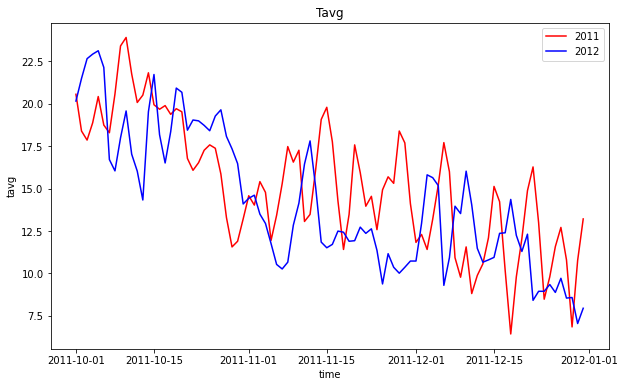

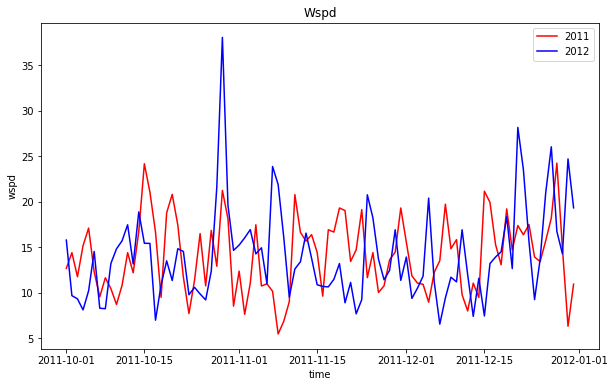

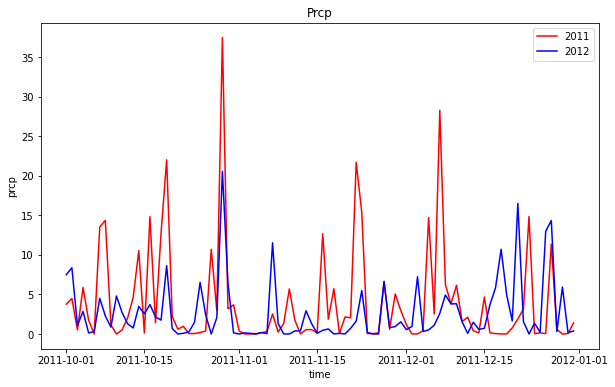

In [39]:

# time_axes = 
col_list = ['tavg', 'wspd', 'prcp']

for col in col_list:
    fig, ax = plt.subplots(figsize=(10,6))

    # x = 
    # y = 

    sns.lineplot(x=weather_df_2011['time'], y=weather_df_2011[col], color='r', ci=None, ax=ax, label='2011')
    sns.lineplot(x=weather_df_2011['time'], y=weather_df_2012[col], color='b', ci=None, ax=ax, label='2012')
    
    ax.set_title(col.capitalize())
    #ax.legend()
    plt.show()

In [40]:
column_list = weather_df.columns
for col in column_list[2:]:
    weather_df[weather_df['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)

TypeError: no numeric data to plot

In [ ]:
# good to work with temperature and windspeed
# maybe perspiration

column_list = ['tavg', 'wspd', 'prcp']
for col in column_list:
    weather_df[weather_df['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)

In [ ]:
display(stations_dict)
# create a list of airports ordered by the course of the hurricane
ordered_airports = ['TJSJ', 'KMIA', 'KPHL', 'KJFK', 'KEWR', 'KBOS']

In [ ]:
# plot only the average temperature for all airports
for airport in ordered_airports:
    weather_df[weather_df['icao'] == airport].plot(kind='line', x='time', y='wspd', figsize=(8,6), rot=90)

In [ ]:
# plot only the average temperature for all airports
for airport in ordered_airports:
    weather_df[weather_df['icao'] == airport].plot(kind='line', x='time', y='prcp', figsize=(8,6), rot=90)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

In [73]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389158 entries, 0 to 389157
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_date     389158 non-null  datetime64[ns]
 1   dep_time        379506 non-null  float64       
 2   sched_dep_time  389158 non-null  int64         
 3   dep_delay       379506 non-null  float64       
 4   arr_time        379210 non-null  float64       
 5   sched_arr_time  389158 non-null  int64         
 6   arr_delay       378602 non-null  float64       
 7   airline         389158 non-null  object        
 8   tail_number     386021 non-null  object        
 9   flight_number   389158 non-null  int64         
 10  origin          389158 non-null  object        
 11  dest            389158 non-null  object        
 12  air_time        378602 non-null  float64       
 13  distance        389158 non-null  float64       
 14  cancelled       389158 non-null  int

In [ ]:
results

In [74]:
corr = flight_data.corr()

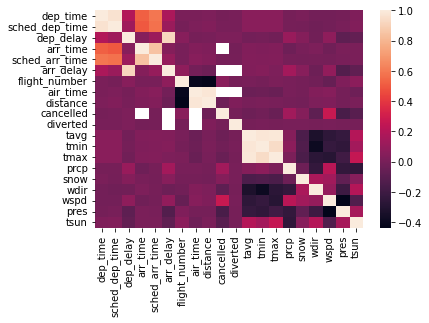

In [81]:
sns.heatmap(corr);

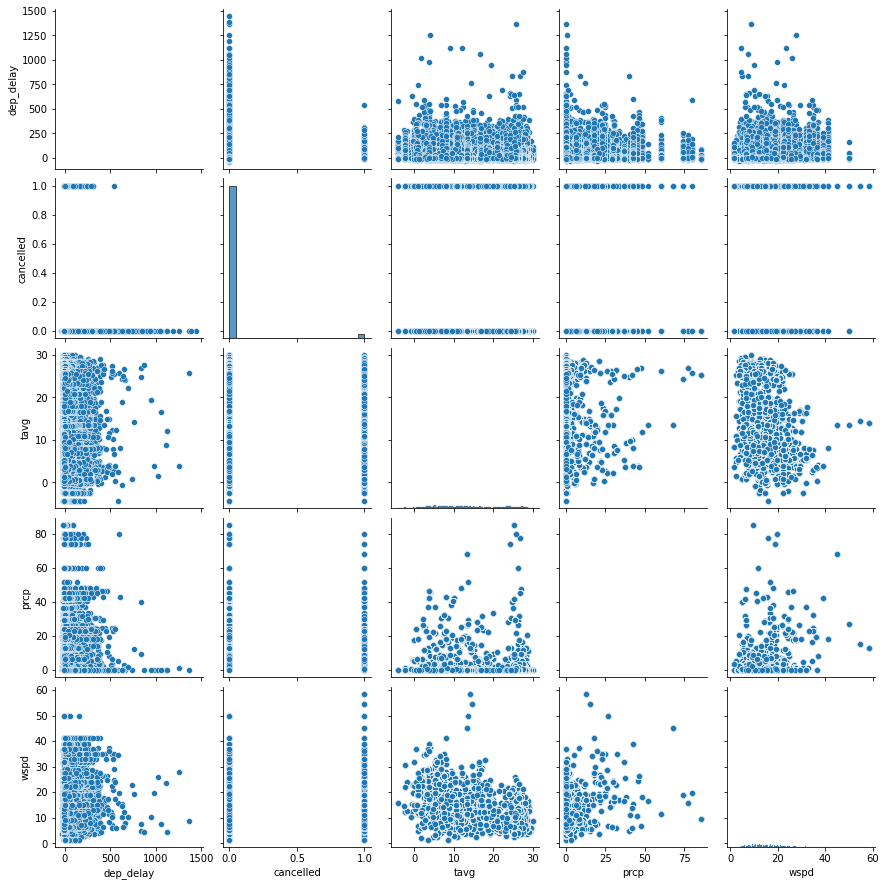

In [86]:
sns.pairplot(flight_data[['dep_delay', 'cancelled', 'tavg', 'prcp', 'wspd']])

In [96]:
data_sub = flight_data[(flight_data['flight_date'].dt.year == 2012) & (flight_data['flight_date'].dt.month == 10) & (flight_data['flight_date'].dt.day >= 20) & (flight_data['flight_date'].dt.day <= 26)]
smf.ols(formula='cancelled ~ wspd', data=data_sub).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cancelled   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.843
Date:                Mon, 08 Nov 2021   Prob (F-statistic):             0.0918
Time:                        20:45:31   Log-Likelihood:                 12465.
No. Observations:                8197   AIC:                        -2.493e+04
Df Residuals:                    8195   BIC:                        -2.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.335      0.738      -0.002       0.003
wspd           0.0002      0.000      1.686      0.092   -3.22e-05       0.000
==============================================================================
Omnibus:                    17340.784   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42596558.233
Skew:                          18.789   Prob(JB):                         0.00
Kurtosis:                     354.150   Cond. No.                         32.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
smf.ols(formula='cancelled ~ prcp', data=flight_data[(flight_data['flight_date'].dt.year == 2012) & (flight_data['flight_date'].dt.month == 10)]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cancelled   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4018.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:42:51   Log-Likelihood:                -2568.2
No. Observations:               36334   AIC:                             5140.
Df Residuals:                   36332   BIC:                             5157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0415      0.002     27.595      0.000       0.039       0.044
prcp           0.0134      0.000     63.387      0.000       0.013       0.014
==============================================================================
Omnibus:                    19638.806   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116745.262
Skew:                           2.667   Prob(JB):                         0.00
Kurtosis:                       9.975   Cond. No.                         7.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""